# Portfolio Optimization

**The process of optimizing a portfolio is essentially selecting an asset distribution in order to achieve a certain goal.** This optimal portfolio depends on the objective, but usually is associated with maximizing your returns or minimizing the risk. In this article, we’ll try to **optimize a portfolio by maximizing the sharpe ratio** of our portfolio.

We’ll first discuss about some basic concepts in portfolio theory, and then we’ll write a code to optimize the portfolio.

# Table of Contents

1. [Modern Portfolio Theory](#Modern-Portfolio-Theory-(MPT))
    1. [Portfolio's Return](#Portfolio's-Return)
    2. [Risk](#Risk)
    3. [Example with Two Stocks](#Example-with-Two-Stocks)
2. [Efficient Frontier](#efficient-frontier)
3. [Risk-free Assets](#risk-free-assets)
4. [Sharpe Ratio](#sharpe-ratio)
5. [Capital Market Line](#capital-market-line)
6. [Optimal Portfolio with Python](#optimal-portfolio-with-python)
    1. [Daily Returns](#daily-returns)
    2. [Negative Sharpe Ratio](#negative-sharpe-ratio)
    3. [Constraits and Bounds](#constraints-and-bounds)
    4. [Initial Weights](#initial-weights)
    5. [Minimize](#minimize)
    6. [Portfolio Distribution Plot](#portfolio-distribution-plot)
7. [Portfolio Simulation](#portfolio-simulation)
    1. [Monte Carlo Method](#monte-carlo-method)
    2. [Multidimensional Geometric Brownian Motion (M-GBM)](#multidimensional-geometric-brownian-motion-m-gbm)
8. [Code](#code)
    1. [Monte Carlo Function](#monte-carlo-function)
    2. [Analyzing the Results](#analyzing-the-results)
    3. [Expected Return](#expected-return)
    4. [Standard Deviation](#standard-deviation)
    5. [Value at Risk (VaR)](#value-at-riskvar)
    6. [Distribution](#distribution)
9. [Bibliography](#bibliography)

# Modern Portfolio Theory (MPT)

A portfolio is a combination of investments. These investments can have different natures, such as stocks, bonds, cash, etc. **Every asset within a same class has two main attributes that differ them from each other, which are the return and the variance or risk.**

**The [Modern Portfolio Theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory) (or mean-variance analysis) is a concept in finance which propagates the idea of building a portfolio that maximizes the expected return for a given level of risk.** A key part of the theory is that **[diversification](https://en.wikipedia.org/wiki/Diversification_(finance))** in investing reduces the risk of your portfolio. Investors could achieve better results by choosing an optimal combination of investments based on an assessment of their own individual tolerance to risk.

## Portfolio's Return
**A portfolio's return is the logarithmic change in value after a specified period.** We can calculate the returns of each asset with:

$$R_i = ln(\frac{S_{i, t+1}}{S_{i, t}})$$

where:
- $S_{i, t}$ if the price of asset $i$ in time $t$.
- $S_{i, t+1}$ if the price of asset $i$ in time $t + 1$.

For each asset, we can calculate its [expected return](https://en.wikipedia.org/wiki/Rate_of_return), by taking the mean of daily returns in a sample:
$$R = [R_1, R_2, ..., R_m]'$$
$$\alpha_i = mean[R_i]$$
$$E[R] = \alpha = \begin{bmatrix} \alpha_1 \\\ \alpha_2 \\\ : \\\ \alpha_m \end{bmatrix}$$

We can think of a portfolio as a list, or vector, of weights that represent how our capital is distributed among the assets:

$$w = (w_1, w_2, ..., w_m)$$

Then, **the expected return of our portfolio would be the sum of weights of each asset multiplied by its expected return**:

$$E[R_w] = w'\alpha = (\alpha_1w_1) + (\alpha_2w_2) + ... + (\alpha_mw_m)$$

## Risk
Each asset has it's own variance. **We can combine the variance of each asset by just adding up each independent variance. However, we also have to account for possible covariances between different assets.**

In a portfolio with two assets, the variance would be:

$$var[R_w] = var[R_1] + var[R_2] + 2cov[R_1, R_2]$$

For a portfolio with $m$ assets, we first define a covariance matrix:

$$Cov[R] = \Sigma = \begin{bmatrix}
  \Sigma_{1, 1} & ... & \Sigma_{1, m} \\
  : & ... & : \\
  \Sigma_{m,1} & ... & \Sigma{m, m}
\end{bmatrix}$$

where:
- $\Sigma_{i, i}$ represents the variance of the returns in asset $i$.
- $\Sigma_{i, j}$ represents the covariance between the returns of assets $i$ and $j$.

Then, we can calculate the variance of our portfolio as:

$$var[R_w] = \sigma^2 = w'\Sigma w$$

With the variance, we can also calculate the standard deviation of our portfolio.

$$std[R_w] = \sigma = \sqrt{w'\Sigma w}$$

**Both are measures the volatility or risk in our portfolio.**

## Example with Two Stocks

Let's use some real data as an example.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# With yfinance, we retrieve historical closing prices of WMT and AMZN stocks
prices = yf.download(['WMT', 'AMZN'], start='2010-01-01', auto_adjust=False)['Adj Close']

# Calculate the daily returns of each stock
returns = np.log(prices / prices.shift())

[*********************100%***********************]  2 of 2 completed


We will define two functions to calculate the return and the risk of our portfolio.

In [2]:
def portfolio_return(returns, weights):
    """
    Takes the dataframe of daily returns and multiply by the respective weight,
    while also annualizing by multiplying by the number of trading days.
    """

    return np.sum(returns.mean() * weights) * 252

def portfolio_risk(returns, weights):
    """
    Calculates the covariance matrix of the daily returns, adjusting for a year,
    and then calculates the standard deviation of the portfolio using the given
    weights.
    """

    cov_matrix = returns.cov() * 252 # Calculate the covariance matrix

    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    return risk

Then, for multiple combinations of weights, we can calculate the risk and return of those portfolios.

In [3]:
# Create a set of weights for the first stock
possible_weights = np.linspace(0, 1, 100)

portfolios = []

for w1 in possible_weights:

    # The two weights sum up to 1 or 100%
    w2 = 1 - w1
    weights = np.array([w1, w2])

    # Calculate the risk and return for a given combination of weights (portfolio)
    curr_risk = portfolio_risk(returns, weights)
    curr_return = portfolio_return(returns, weights)

    portfolios.append([curr_risk, curr_return])

portfolios = np.array(portfolios)

Also, we’ll highlight the portfolio with the lowest volatility and use it as a divider between portfolios with returns lower and higher than it.

In [4]:
# Look for the portfolio with the lowest volatility
min_risk_idx = np.argmin(portfolios[:, 0])
min_risk_risk = portfolios[min_risk_idx, 0]
min_risk_return = portfolios[min_risk_idx, 1]

# Divide the portfolios into efficient and inefficient according to the efficient frontier
efficient_mask = portfolios[:, 1] >= min_risk_return
efficient_portfolios = portfolios[efficient_mask]
inefficient_portfolios = portfolios[~efficient_mask]

Finally, we can plot all the portfolios in a [risk x return](https://en.wikipedia.org/wiki/Risk–return_spectrum) graph.

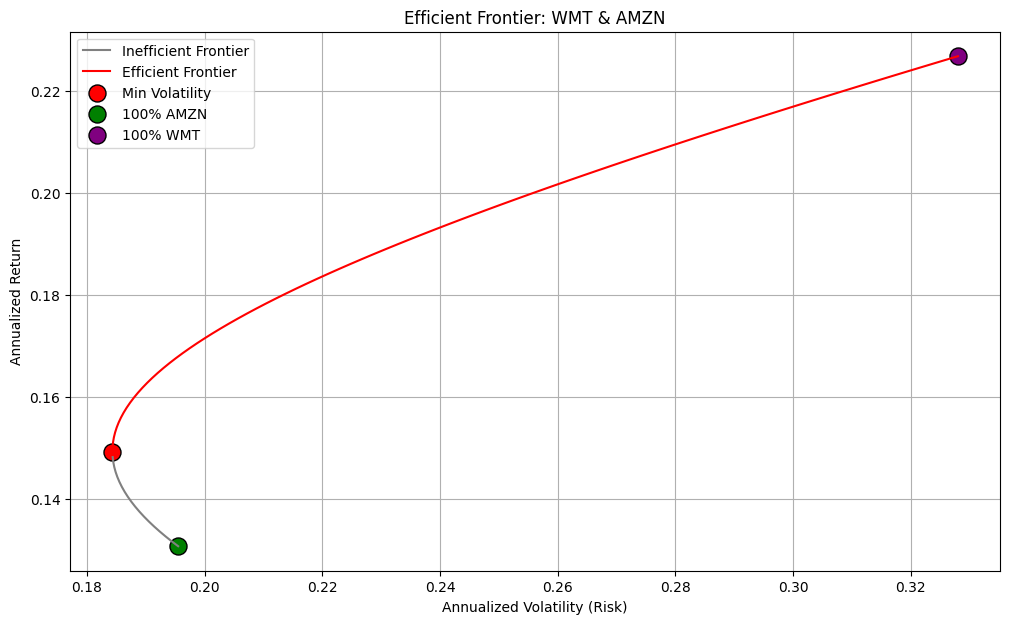

In [5]:
# Create a return x volatility plot for all portfolios
plt.figure(figsize=(12, 7))
plt.plot(inefficient_portfolios[:, 0], inefficient_portfolios[:, 1], c='gray', label='Inefficient Frontier')
plt.plot(efficient_portfolios[:, 0], efficient_portfolios[:, 1], c='red', label='Efficient Frontier')

# Highlight the portfolios with minimum risk and with 100% allocated to each stock
plt.scatter(min_risk_risk, min_risk_return, c='red', s=150, edgecolors='black', label='Min Volatility')
plt.scatter(portfolios[0, 0], portfolios[0, 1], c='green', s=150, edgecolors='black', label='100% AMZN')
plt.scatter(portfolios[-1, 0], portfolios[-1, 1], c='purple', s=150, edgecolors='black', label='100% WMT')

plt.title('Efficient Frontier: WMT & AMZN')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()


# Efficient Frontier

As we can see int the plot above, **the portfolios corresponding to the gray line, represent sub-optimal portfolios**. That’s because there are other combinations of weights which have the same risk, but with higher returns. So the optimal portfolios, which are represented **by the red line or the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier), are the portfolios which are worth analyzing**.

The red marker is the portfolio with the lowest amount of risk. This portfolio divides the efficient frontier from the sub-optimal portfolios.

**We can choose any portfolio within the efficient frontier, according to the MPT, this only depends on the risk we’re willing to take, since higher risk equals higher returns.** So, one way we could optimize our portfolio is by defining a level of volatility, and looking for the distributions of weights that would result in the highest expected return.

# Risk-free Assets

One thing we should also consider is the existence of risk-free assets. In practice, risk-free assets can be seen as the yield of bonds issued by stable governments. Even though, there is always a risk of a government defaulting, the odds are so low compared to the volatility of other assets, that it’s acceptable to think of them as risk-free. **Since you could obtain a rate of return from zero risk, any other risky investment will have to have a higher rate of return in order to induce any investors to hold it.** In other words, besides finding an optimal balance of risky assets in our portfolio, we can also allocate part of our capital in a risk-free asset.

# Sharpe Ratio

Another way we can measure the performance of our portfolio is by looking at its Sharpe Ratio. The [Sharpe Ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) is an indicator that combines the return ($R_p$) and standard deviation ($\sigma_p$) of our portfolio and the risk-free rate of return ($R_f$). In short, the Sharpe Ratio indicates how much extra return we get from every unit of risk taken.

$$Sharpe\ Ratio = \frac{R_p - R_f}{\sigma_p}$$

With the Sharpe Ratio, we can compare different portfolios taking both risk and return into account. The higher the Sharpe Ratio, the better our portfolio did coverting its risk into excess returns. **This means that we can maximize our Sharpe Ratio to find a optimal portfolio.**

# Capital Market Line

When we consider risk-free investments, our set of possible optimal portfolios change. **The way we can visualize this is by first taking the rate of return of the risk-free asset and plotting in the volatility x return graph. Then, we trace a straight line, tangent to the efficient frontier and starting at the risk-free rate.** This line is called the [Capital Market Line](https://en.wikipedia.org/wiki/Capital_market_line) (CML).

In [6]:
def sharpe_ratio(portfolio_return, portfolio_volatility, rf=0.042):
    """
    Calculates the Sharpe Ratio by taking the return and volatility of
    the portfolio and a risk-free rate of return.
    """
    return (portfolio_return - rf) / portfolio_volatility

In [7]:
max_sharpe = 0
max_efficient_portfolio = []

# Iterate through all the portfolios, looking for the one with the highest Sharpe Ratio
for risk, rp in portfolios:
    
    portfolio_sharpe = sharpe_ratio(rp, risk)

    if portfolio_sharpe > max_sharpe:
        max_sharpe = portfolio_sharpe
        max_efficient_portfolio = [risk, rp]

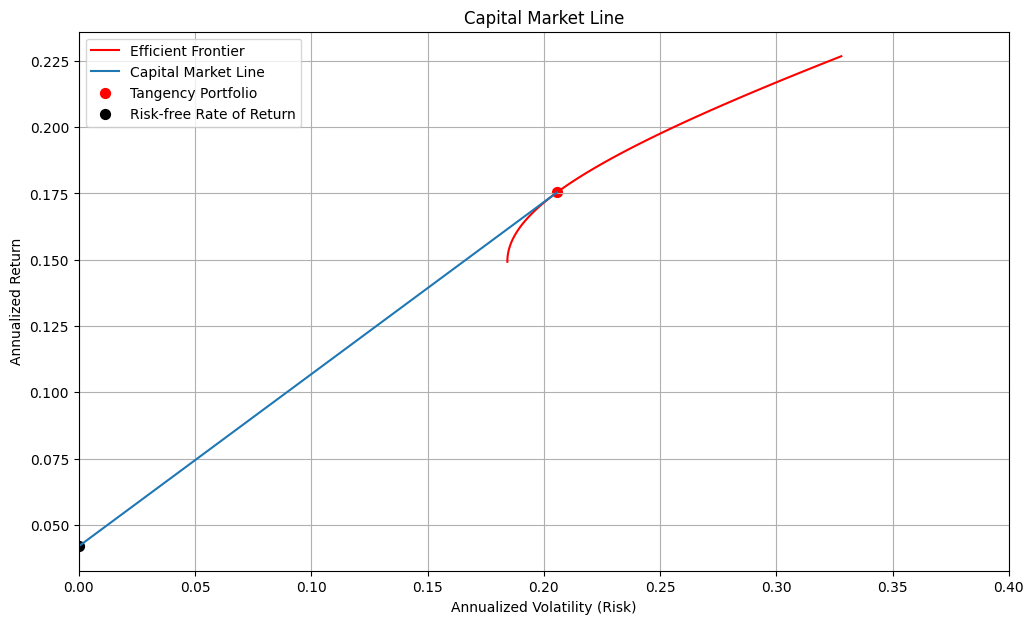

In [8]:
# Create a plot with the efficient frontier + CML
plt.figure(figsize=(12, 7))

# Plot the efficient frontier from last example
plt.plot(efficient_portfolios[:, 0], efficient_portfolios[:, 1], c='red', label='Efficient Frontier')
# Plot a straight line between the risk-free rate and the optimal risky portfolio
plt.plot([0, max_efficient_portfolio[0]], [0.042, max_efficient_portfolio[1]], label='Capital Market Line')

plt.scatter(max_efficient_portfolio[0], max_efficient_portfolio[1], c='red', s=50, label='Tangency Portfolio')
plt.scatter(0, 0.042, c='black', s=50, label='Risk-free Rate of Return')

plt.title('Capital Market Line')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.xlim(0, 0.4)
plt.legend()
plt.grid(True)
plt.show()


The point where the CML and the Efficient Frontier meet represents the portfolio with the highest Sharpe Ratio, which means is also the most efficient portfolio of risky assets. **This portfolio is also called the tangency portfolio.** The starting point of the CML represents a portfolio only invested in a risk-free asset. **Every portfolio that falls on top of the CML is a mix of the most efficient portfolio and the risk-free asset.** For that reason, the efficient frontier doesn’t correspond to the set of optimal portfolios anymore, since there are options of portfolios with higher returns and lower risk when we combine risky and risk-free assets. Now, the set of optimal portfolios can be seen as the portfolios in the CML.

The formula for the Capital Market Line would be:

$$E[R_{CML}] = R_f + \frac{E[R_t] - R_f}{\sigma_t}\sigma_{CML}$$

where:
- $E[R_{CML}]$ is the expected return of the CML portfolio.
- $R_f$ is the risk-free rate of return.
- $E[R_t]$ is the expected return of the tangency portfolio.
- $\sigma_t$ is the risk of the tangency portfolio.
- $\sigma_{CML}$ is the risk of the CML portfolio.

The term $\frac{E[R_t] - R_f}{\sigma_t}$ is simply the Sharpe Ratio of the tangency or optimal risky portfolio, which is the slope of the CML. The formula says that the expected return of any portfolio on the line is the risk-free rate plus the risk of that portfolio multiplied by the sharpe ratio of the tangency portfolio, or "price of risk".

# Optimal Portfolio with Python

With all the basic concepts in mind, we can write a code to find an optimal portfolio in python. **The code will look for a distribution of weights for a set of stocks, that will maximize the Sharpe Ratio of the portfolio.**

## Daily Returns

We will first retrieve the daily closing prices of the S&P500 companies using the `yfinance` library. We'll get a list of the companies from the S&P500 wikipedia page.

In [9]:
import pandas as pd
import requests

# Scrape from the wikipedia page the list of S&P500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

r = requests.get(url, headers=headers)

table = pd.read_html(r.text)[0]

# Get just the tickers
tickers = table['Symbol'].tolist()

/var/folders/fd/kwdsmhc146j9m05_slkbxp7w0000gn/T/ipykernel_90767/3843953883.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(r.text)[0]


In [10]:
# Retrieve the closing prices with yfinance
prices = yf.download(tickers, start='2020-01-01', auto_adjust=False)['Adj Close']
prices = prices.dropna(axis=1)
returns = np.log(prices / prices.shift())

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-09-07)')
['EFX']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [11]:
returns

Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.016186,-0.009770,-0.009537,-0.012266,-0.001153,-0.001667,-0.007865,-0.017760,-0.001954,-0.002116,...,0.001700,-0.014944,0.004798,-0.008072,0.005869,-0.013089,-0.003137,-0.002617,-0.011996,0.000149
2020-01-06,0.002952,0.007936,0.007861,0.005225,0.003914,-0.006552,0.005710,-0.011818,-0.007853,0.001353,...,-0.002040,-0.001981,-0.001437,0.007649,-0.006495,-0.006849,-0.000589,-0.005796,0.007626,-0.007707
2020-01-07,0.003061,-0.004714,-0.005721,-0.005575,-0.008307,-0.021827,-0.000959,0.022496,-0.012119,-0.012179,...,-0.006488,0.004734,-0.002079,-0.008218,-0.003767,0.031774,0.001767,-0.000879,-0.005987,0.003374
2020-01-08,0.009824,0.015958,0.007062,0.004068,-0.010013,0.001960,0.013348,0.008991,-0.011146,0.009354,...,0.003761,0.006254,-0.000961,-0.015195,0.003391,0.045548,0.001764,0.011903,-0.035036,-0.002173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-29,0.005586,-0.001808,0.011857,0.009772,0.003612,0.014725,0.007711,-0.011631,-0.000319,-0.000164,...,0.005038,0.000079,0.000691,0.008259,-0.017159,-0.014213,0.010259,0.009850,-0.015366,0.010347
2025-09-02,-0.003588,-0.010479,0.007198,-0.009087,-0.002297,-0.014725,-0.031526,-0.008022,-0.009464,-0.014177,...,-0.038618,-0.010150,-0.003459,0.003494,-0.008584,-0.043761,-0.005622,-0.010326,-0.032110,-0.022763
2025-09-03,0.000080,0.037382,-0.000283,0.005462,0.017154,-0.007917,0.008269,-0.015298,-0.005332,-0.003040,...,-0.002816,0.000398,0.004012,-0.024538,-0.004642,-0.005789,-0.006138,0.000286,-0.004439,-0.002948


In our experiment, we will restrict our set to stocks from the S&P500 companies since 2020. In reality this is not a good practice. It’s always good to diversify our assets, with mid or small caps and even global stocks. Also, it’s recommended to use a bigger timeframe. There are techniques to deal with the impact of the pandemic as well.

But, it would take longer to run the tests. Since this is only for educational purposes, we don’t have to go that far.

## Negative Sharpe Ratio

To optimize our portfolio, we have to maximize our Sharpe Ratio. However, since we’re using the `minimize` method from `scipy.optimize` library, we’ll define a function to calculate the negative Sharpe Ratio. **So, instead of maximizing the Sharpe Ratio, we’ll minimize the negative Sharpe Ratio.** This is called the [loss function](https://en.wikipedia.org/wiki/Loss_function) or cost function, which we want to minimize in order to get a better performance.

The loss function takes a array of weights (portfolio), the daily returns of stocks and the risk-free rate as inputs. First, it calculates the risk and volatility, given the weights, and then returns the negative Sharpe Ratio.

In [12]:
def neg_portfolio_sharpe(weights, returns, rf=0.0):
    """
    Calculates the negative Sharpe Ratio given the weight distribution,
    daily returns of each stock and a risk-free rate of return.
    """

    p_returns = portfolio_return(returns, weights)

    p_risk = portfolio_risk(returns, weights)

    sharpe = (p_returns - rf) / p_risk

    return -sharpe

## Constraints and Bounds

Next, we set some constraints and bounds for the optimization. There are multiple types of limitations we can add to our portfolio. In this example, we’ll set two different limitations.

**The first is a constraint that the sum of all weights is equal to 1.** That means that our capital will be 100% allocated.

**The second is a boundary that for each weight the minimum value is 0 and the maximum is 0.5.** This is because we won’t allow short positions, so we won’t have negative weights. Also, we don’t want a single asset to have a weight greater than 50%, since we want a diversified portfolio.

In [13]:
# This constraint means that the sum of all weights minus 1 must be equal to zero
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# This creates an array of (0, 0.5) for each stock
bounds = [(0, 0.5) for _ in range(returns.shape[1])]

## Initial Weights

For every optimization problem, we have to start at an initial guess of what the weights would be. The optimization algorithm will work from this starting point and look for changes in the weights that would result higher Sharpe Ratio (or lower negative Sharpe Ratio). **For our initial weights, we’ll just have a uniform distribution among all the stocks.** A more robust approach would be to create a set of random initial weights, and use those as starting points, reducing the bias and the likelihood falling on a local minimum. However, since this is a first experiment, we’ll stick to a more basic technique.

In [14]:
initial_weights = np.array([1 / returns.shape[1]] * returns.shape[1])

## Minimize

The [optimization](https://en.wikipedia.org/wiki/Optimization_problem) is done using the `optimize.minimize` function from the `scipy` library. We'll input the loss function, initial weights, extra arguments for the loss function (returns and risk-free rate), which type of solver, constraints and bounds.

The method `SLSQP` is a iterative algorithm that is used for solving nonlinear optimization problems with constraints. **It is widely used for its effiency and robustness, being able to solve nonlinear problems with both equality and inequality constraints.** Although, it can be quite sensitive to the initial guess. That's why it's recommended to test different starting points.

In [15]:
from scipy.optimize import minimize

optimized_results = minimize(neg_portfolio_sharpe, initial_weights, args=(returns, 0.02),
                             method='SLSQP', constraints=constraints, bounds=bounds)

In [16]:
# The weights of the minimize results is the x attribute
optimized_weights = optimized_results.x

From the results of the `minimize` function, we can get the parameter `x`, which refer to the weights that leads to the lowest negative sharpe ratio found. Some of the weights from the optimized results are very small compared, less than 0.1%, so we'll discard them.

For our optimal portfolio, we can calculate the expected annualized return, volatility and Sharpe Ratio.

In [17]:
optimized_return = portfolio_return(returns, optimized_weights)
optimized_volatility = portfolio_risk(returns, optimized_weights)
optimized_sharpe = sharpe_ratio(optimized_return, optimized_volatility)

print('------ Optimal Portfolio ------')
print(f"Annualized Returns: {optimized_return:.2f}")
print(f"Annualized Volatility: {optimized_volatility:.2f}")
print(f"Annualized Sharpe Ratio: {optimized_sharpe:.2f}")
print(f'Number of Stocks in Portfolio: {len(optimized_results.x[optimized_results.x > 0.0001])}')

------ Optimal Portfolio ------
Annualized Returns: 0.33
Annualized Volatility: 0.21
Annualized Sharpe Ratio: 1.39
Number of Stocks in Portfolio: 15


A annualized return of 33% is exceptionally high, way higher than the average for a S&P500 index. However, a higher return is accompanied by a higher risk. **Even though an annualized volatility of 20% is a moderately high risk, it’s expected from a portfolio composed only of stocks.**

To put it in perspective, in any given year, there’s a roughly 68% chance that the portfolio’s return will be within one standard deviation of the average. This means you can expect the annual return to fall somewhere between 12% (33% — 21%) and 54% (33% + 21%).

**A Sharpe Ratio of 1.39 indicates that the investment is generating more return than its associated risk, since it’s higher than 1.0.** The portfolio is generating a high amount of return for every unit of risk it takes on, proving its efficience.

## Portfolio Distribution Plot

One way to visualize the portfolio's weight distribution is to plot "part of whole" graphs, which represents the percentage allocated to each stock by an area. A very common graph of this type is the pie chart. However, it's also often [critized](https://www.data-to-viz.com/caveat/pie.html), mainly because people are pretty bad at reading angles. So, we're going to use another type of plot similar to the pie chart, but easier to read, which is the treemap.

First, we create a DataFrame with the symbols and weights for our portfolio.

In [ ]:
# Portfolio DataFrame
optimized_symbols = returns.columns[optimized_weights > 0.0001]
optimized_weights = optimized_weights[optimized_weights > 0.0001]
optimized_portfolio = pd.DataFrame([optimized_symbols, optimized_weights], index=['Symbol', 'Weight']).T

We'll group all the stocks with weights smaller than 3%. These assets have a very low impact compared to the rest, so, we're not really worried about them.

In [ ]:
# Group smaller stocks into a Other Stocks category
optimized_portfolio.loc[optimized_portfolio['Weight'] < 0.03, 'Symbol'] = 'Other Stocks'
optimized_portfolio = optimized_portfolio.groupby('Symbol')['Weight'].sum().reset_index()

Next, we're also interested in knowing the allocation distribution by sector. We'll use the same table we first used to retrieve the stocks' tickers.

In [ ]:
# Create a map between symbol and sector
sector_map = table[['Symbol', 'GICS Sector']].set_index('Symbol').to_dict()['GICS Sector']
sector_map['Other Stocks'] = 'Other'

# Add a new column with the respective sectors
optimized_portfolio['Sector'] = [sector_map[stock] for stock in optimized_portfolio['Symbol']]

# Sort the rows by weight
optimized_portfolio.sort_values(by='Weight', ascending=False, inplace=True)

Another aesthetic choice, which also helps distinguish the different sectors, is to color-code the stocks by their sector.

In [ ]:
from pypalettes import load_cmap

# Create color map by sector
cmap = load_cmap('Acadia')
category_codes, unique_categories = pd.factorize([sector_map[stock] for stock in optimized_portfolio['Symbol']])
colors = [cmap(code) for code in category_codes]

# Create labels wtih ticker, sector and weight
labels = [f"{symbol}\n{sector}\n{weight*100:.2f}%" for symbol, weight, sector in zip(optimized_portfolio['Symbol'], 
                                                                                     optimized_portfolio['Weight'], 
                                                                                     optimized_portfolio['Sector'])]

/var/folders/fd/kwdsmhc146j9m05_slkbxp7w0000gn/T/ipykernel_90767/3546917103.py:4: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  category_codes, unique_categories = pd.factorize([sector_map[stock] for stock in optimized_portfolio['Symbol']])


To plot the treemap graph, I used the `squarify` library and followed the tutorial on the [Python Graph Gallery](https://python-graph-gallery.com/treemap/).

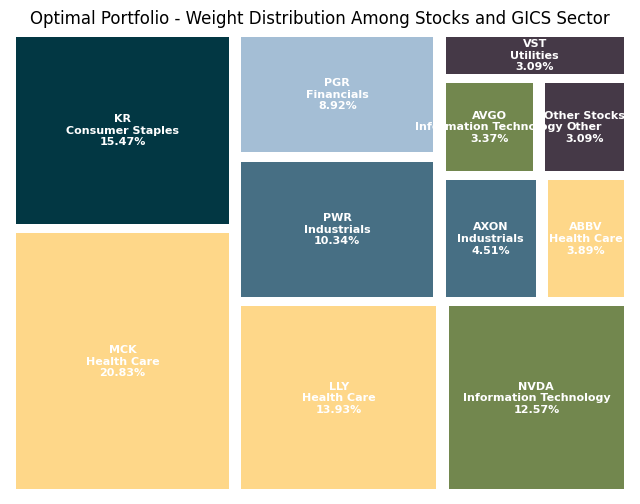

In [ ]:
import squarify

plt.figure(figsize=(8, 6))
squarify.plot(sizes=optimized_portfolio['Weight'], 
              label=labels, 
              color=colors, 
              text_kwargs={'color':'white',
                           'fontsize':8,
                           'fontweight':'bold'},
              pad=True)

plt.axis('off')
plt.title('Optimal Portfolio - Weight Distribution Among Stocks and GICS Sector')
plt.show()

The plot above shows the composition of our portfolio. **The portfolio is mainly distributed among 10 different stocks, with a relatively small percentage allocated to other five.** Given the set of almost 500 companies, this is not necessarily a diversified portfolio. However, this is the weight distribution that led to the highest Sharpe Ratio. The majority of the portfolio is allocated in Health Care companies followed by a equal amount in Consumer Staples, Industrials and Information Technology. All of those have shown a pretty consistent growth in the past few years.

The results of a optimization problem depend on many factors, such as the initial guess or the minimizing method. Other local minimum could end up being found, resulting in a different distribution of stocks, meaning there could be other solutions.

# Portfolio Simulation

With our portfolio constructed, **we can simulate multiple scenarios and calculate its expected returns based on the assumption that stock prices follow a [Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)**. The process is to first generate normally distributed random variables to forecast stock prices using the volatility and expected return of each asset. Then, we’ll simulate a number of portfolios by calculating its expected returns with the weights and forecasted returns of each stock. Finally, we can calculate the average of the expected returns, and study the distribution of the results.

## Monte Carlo Method

A [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method) is often to model events with significant uncertainty in inputs. **The technique is to forecast multiple results from a randomly generated inputs.** Once the simulation is complete, we can draw some statistics from the outputs, like average, variance and intervals of confidence.

## Multidimensional Geometric Brownian Motion (M-GBM)

In a [previous story](https://medium.com/@andrejin.nagano/black-scholes-option-pricing-model-formula-6438c1c22720), I discussed the concept of Geometric Brownian Motion (GBM) and why we can use it to model the movements of stock prices. But simply put, **a GBM is a stochastic process in which the change in position is given by a drift parameter and a volatility parameter multiplied by a random variable**.

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

It is often used to model the random behaviour of stock prices because of its lognormal distribution.

However, the GBM model only works for a single stock's movement. **When we analyze the movement of multiple assets at once, we can't only consider the independent variances of each stock, we also have to count for covariances between them.** That's why when we are modeling the movements of several stocks we have to use a multidimensional GBM.

The stochastic differential equation for a M-GBM is as follows:

$$dS_t = diag(\mu) S_t dt + diag(S_t) \Sigma dW_t$$

where:
- $S_t$ is the vector of stock prices at period $t$.
- $\mu$ is the vector of drift percentages, or expected values, for each stock.
- $diag()$ is a diagonal matrix of the vector.
- $\Sigma$ is the volatility matrix or covariance matrix.
- $W_t$ is a vector of independent standard Wiener processes.

This formula is similar to the standard GBM, but **instead of having a single volatility parameter ($\sigma$), now we have a volatility matrix**.

Each row of the volatility matrix ($\Sigma$) represents a stock, with its variance and [covariances](https://en.wikipedia.org/wiki/Covariance) with the other stocks. In short, the covariance tells us the direction of the linear relationship between two variables. The more positive a covariance is, the more the two variables tend move in the same direction. The more negative a covariance is, the more the two variables tend to move in opposite directions.

The solution for this SDE is given by:

$$S_T = S_0 exp ((\mu - \frac{diag(\Sigma)}{2})T + LW_T)$$

The $LW_T$ is the vector of correlated random shocks. We use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to obtain the lower triangular matrix $L$, and then we multiply it by the Wiener processes vector $W$. 

$$\Sigma = L L^T$$

**When we multiply the Cholesky matrix $L$ by the vector of independent Wiener processes $W$, we are creating a new matrix with correlated random shocks.** Since the stock prices are not independent, a random shock in one price has an impact on another based on the covariance between the two. The purpose of the $L$ matrix is to transform random numbers into correlated random numbers, like explained previously.

## Code

### Monte Carlo Function

Next, we define the Monte Carlo simulation function. **This function simulates multiple times the returns of our portfolio in a set time horizon.**

First, the function creates an empty array where all the final values of each portfolio will be stored. Then, we calculate the expected daily return of each stock ($\mu$) and the covariance matrix ($\Sigma$).

For each simulation we generate random shocks ($W$), multiplying it by the lower triangle matrix from the Cholesky decomposition ($L$). With the solution to the M-GBM SDE, we estimate the daily returns for each stock for the set time horizon.

We can accumulate the daily returns, and multiply by the weights in our portfolio, which results in the final value of the portfolio after the defined time horizon. **The output of this function is an array with all the final values of each simulation.**

In [25]:
def monte_carlo(returns, weights, initial_investment, time_horizon_years, num_simulations):
    """
    Runs a correlated Monte Carlo simulation for a portfolio using M-GBM.
    """

    # Define the time horizon for the simulation
    num_trading_days = 252
    time_horizon_days = num_trading_days * time_horizon_years
    num_assets = len(returns.columns)
    
    # Array to store the final portfolio values of each simulation
    final_portfolio_values = np.zeros(num_simulations)
    
    # Calculate the mu parameter and the volatility matrix
    daily_mu = returns.mean()
    daily_cov = returns.cov()
    
    # Calculate the L matrix with the Cholesky Decomposition
    L = np.linalg.cholesky(daily_cov)
    
    # Run the Simulations
    for i in range(num_simulations):

        # Generate vector of independent Wiener processes
        standard_random_shocks = np.random.normal(0, 1, (num_assets, time_horizon_days))
        
        # Calculate the matrix of correlated random shocks
        correlated_shocks = L @ standard_random_shocks
        
        # Calculate the drift component for the M-GBM formula
        drift_component = daily_mu - np.diag(daily_cov) / 2
        
        # Reshape for broadcasting
        drift_component = drift_component.values.reshape(num_assets, 1)
        
        # Calculate daily returns for each asset using M-GBM
        daily_returns = np.exp(drift_component + correlated_shocks)
        
        # Stack a row of ones to represent the starting prices (S0 = 1)
        price_paths = np.vstack([np.ones(num_assets), daily_returns.T])
        
        # Calculate cumulative price paths by multiplying the daily returns
        cumulative_price_paths = price_paths.cumprod(axis=0)
        
        # Calculate the final value of the portfolio for this simulation
        initial_allocations = weights * initial_investment
        final_asset_values = cumulative_price_paths[-1] * initial_allocations
        final_portfolio_values[i] = final_asset_values.sum()

    return final_portfolio_values

We can now run the simulation defining some parameters. For this experiment, we start with $100,000.00, and run 10.000 simulations for a single year.

In [32]:
# Simulation Settings
INVESTMENT = 100000
YEARS = 1
NUM_SIMULATIONS = 10000

# Run the simluation
final_values = monte_carlo(
    returns=returns,
    weights=optimized_results.x,
    initial_investment=INVESTMENT,
    time_horizon_years=YEARS,
    num_simulations=NUM_SIMULATIONS
)

# Calculate statistics
mean_value = np.mean(final_values)
std_value = np.std(final_values)
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)

# Simulation Summary
print("--- Simulation Summary ---")
print(f'Initial Investment: ${INVESTMENT}')
print('---------------------------------')
print(f'Expected Portfolio Value: ${mean_value:,.2f}')
print(f'Standard Deviation of Portfolio Value: ${std_value:,.2f}')
print(f'Worst-Case (5% VaR): ${percentile_5:,.2f}')
print(f'Best-Case (95%): ${percentile_95:,.2f}')

--- Simulation Summary ---
Initial Investment: $100000
---------------------------------
Expected Portfolio Value: $140,385.65
Standard Deviation of Portfolio Value: $31,942.43
Worst-Case (5% VaR): $96,182.10
Best-Case (95%): $197,543.33


## Analyzing the Results

With the results from the Monte Carlo simulations, we can calculate the mean, the 5th and 95th percentile, and the standard deviation. We can also plot a histogram of all the values in the array, and see how the data is distributed.

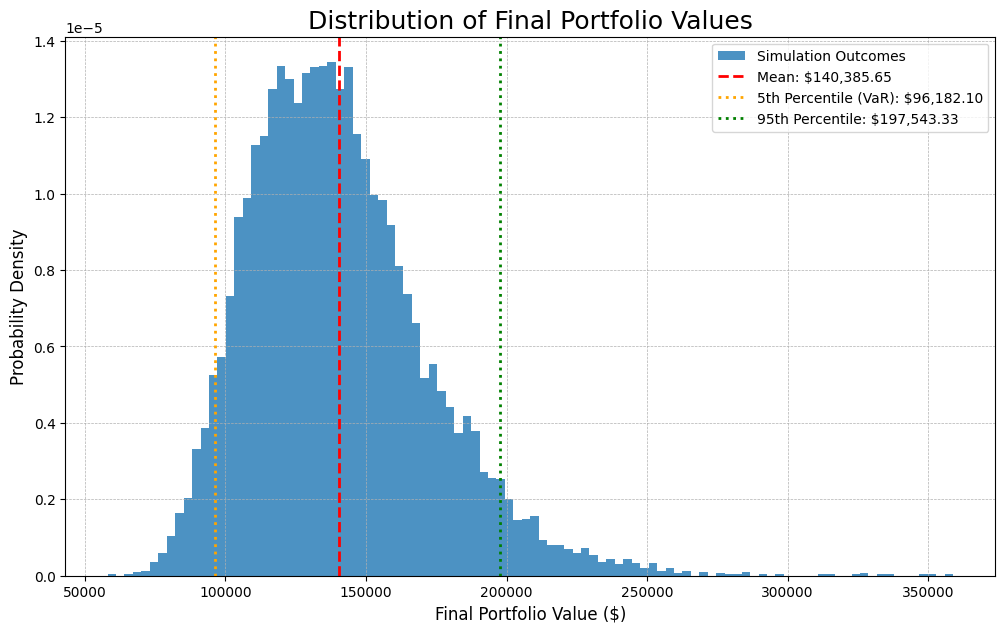

In [33]:
plt.figure(figsize=(12, 7))

# Plot histogram of the distribution of final values
plt.hist(final_values, bins=100, density=True, alpha=0.8, label='Simulation Outcomes')

# Highlight the mean, 5th and 95th percentile
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_value:,.2f}')
plt.axvline(percentile_5, color='orange', linestyle=':', linewidth=2, label=f'5th Percentile (VaR): ${percentile_5:,.2f}')
plt.axvline(percentile_95, color='green', linestyle=':', linewidth=2, label=f'95th Percentile: ${percentile_95:,.2f}')

plt.title('Distribution of Final Portfolio Values', fontsize=18)
plt.xlabel('Final Portfolio Value ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

## Expected Return

The average of all final portfolio values is our expected value after the time horizon. For our Monte Carlo simulations, the expected final portfolio value is $140k. This means that in 1 year, we can expected the investment to increase by 40%.

## Standard Deviation

The standard deviation of all final portfolio values is the primary measure of risk. A metric of $31,942.43 means that there is a approximately 68% change that the value of our portfolio to falls between $108k and $172k.

## Value at Risk (VaR)

**The [Value at Risk](https://en.wikipedia.org/wiki/Value_at_risk) is a metric that quantifies the potential financial loss of an investment over a specified timeframe.** In our Monte Carlo simulation, we see that in 5% of all experiments, the value of the portfolio decreases to lower than $96k. This would mean that there is a 5% chance of the portfolio will lose at least 4% of its value over the next year. **Usually, we use this notation for VaR: the portfolio has a 5% one-year VaR of 4%.**

## Distribution

**One thing to highlight is that the distribution of the portfolio's values is [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution).** This means that the portfolio can't have a negative value at any time and that the distribution has a long tail to the right (positive skew). The reason for that is because the GBM model for stock prices assumes the distribution to be log-normally as well, meaning there is a cap for losses at $0 (stocks are real limited assets) and there are possible unlimited gains.

# Bibliography

For this article, these contents were used as references:

- [MIT 18.S096 Topics in Mathematics with Applications in Finance: Lesson 14 — Portfolio Theory](https://www.youtube.com/watch?v=ywl3pq6yc54)
- [The Capital Market Line by Edspira](https://www.youtube.com/watch?v=wOaKzthMUQ0)
- [Modern Portfolio Theory by Investopedia](https://www.investopedia.com/terms/m/modernportfoliotheory.asp)
- [Efficient Frontier by Investopedia](https://www.investopedia.com/terms/e/efficientfrontier.asp)
- [Sharpe Ratio by Investopedia](https://www.google.com/search?client=safari&rls=en&q=sharpe+ratio&ie=UTF-8&oe=UTF-8)
- [Monte Carlo Simulation: What It Is, How It Works, History, 4 Key Steps by Investopedia](https://www.investopedia.com/terms/m/montecarlosimulation.asp)
- [How to simulate financial portfolios with Python](https://towardsdatascience.com/how-to-simulate-financial-portfolios-with-python-d0dc4b52a278/)
- [The Multi-Underlying Black-Scholes Model and Correlation](https://hsrm-mathematik.de/WS201516/master/option-pricing/Multi-Underlying-Black-Scholes-Model-and-Correlation.pdf)
- [Model Reduction of Multivariate Geometric Brownian Motions and Localization in a Two-State Quantum System](https://arxiv.org/html/2507.09413v1)
- [Black-Scholes Option Pricing Model - Formula](https://medium.com/@andrejin.nagano/black-scholes-option-pricing-model-formula-6438c1c22720)